<a href="https://colab.research.google.com/github/doob09/DL_monkey_classification/blob/main/10_monkey_Spec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Link Dataset on Kaggle:
- https://www.kaggle.com/sachin93/monkey-species-classification-fastai

# 1.Prepare Data

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import os
import shutil 
import opendatasets as od

In [ ]:
dataset_url = 'https://www.kaggle.com/slothkong/10-monkey-species'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: pv0009
Your Kaggle Key: ··········


  4%|▍         | 23.0M/547M [00:00<00:02, 241MB/s]

100%|██████████| 547M/547M [00:02<00:00, 257MB/s]


In [ ]:
# 
data_path = './10-monkey-species'
print(os.getcwd())
print(os.listdir(data_path))

/content
['training', 'validation', 'monkey_labels.txt']


In [ ]:
# count how many items in each folder
train_path = data_path + '/training/training' 
val_path = data_path + '/validation/validation'
list_paths = [train_path, val_path]
for l in list_paths:
    total_items=0
    print('folder name', l )
    for sub_dir in os.listdir(l):
        item_list = os.listdir(l + '/' + sub_dir)
        total_items += len(item_list)
        print(sub_dir, ':', len(item_list))
    print('total item',total_items)

folder name ./10-monkey-species/training/training
n1 : 111
n8 : 106
n6 : 106
n0 : 105
n2 : 110
n3 : 122
n9 : 106
n5 : 113
n4 : 105
n7 : 114
total item 1098
folder name ./10-monkey-species/validation/validation
n1 : 28
n8 : 27
n6 : 26
n0 : 26
n2 : 27
n3 : 30
n9 : 26
n5 : 28
n4 : 26
n7 : 28
total item 272


In [ ]:
import pandas as pd

In [ ]:
cols=['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
info_overview = pd.read_csv(data_path + "/monkey_labels.txt",names=cols,skiprows=1)
info_overview

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


In [ ]:
#labels = info_overview.iloc[:,[2]]
labels= info_overview['Common Name']
print(labels[3])
print(labels)

 japanese_macaque              
0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object


## DataSet

## Using ImageFolder from pytorch

In [ ]:
from torchvision import datasets, transforms

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
train_transform = transforms.Compose([
                                transforms.RandomRotation(25),
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                [0.485, 0.456, 0.406],
                         	                    [0.229, 0.224, 0.225])
                                
])

In [ ]:
val_transform = transforms.Compose([
                                transforms.RandomRotation(25),
                                transforms.Resize(64),
                                transforms.CenterCrop(64),
                                transforms.ToTensor(),
                                transforms.Normalize(
                                                [0.485, 0.456, 0.406],
                         	                    [0.229, 0.224, 0.225])
                                
])

In [ ]:
train_ds = datasets.ImageFolder(train_path, transform=train_transform)
print(len(train_ds))
print(train_ds.classes)

1097
['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']


In [ ]:
val_ds = datasets.ImageFolder(val_path, transform=val_transform)
print(len(val_ds))

272


 mantled_howler                


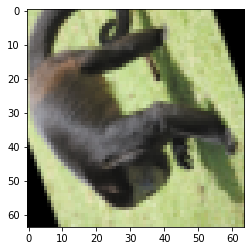

In [ ]:
#show a sample: image with label
image,label = train_ds[30]
plt.imshow(image.permute(2,1,0))
print(labels[label])

## DataLoader

In [ ]:
batch_size = 128

train_dl = DataLoader(train_ds,
                      batch_size,
                      shuffle=True,
                      num_workers=2,
                      pin_memory=True)

val_dl = DataLoader(val_ds,
                      batch_size,
                      num_workers=2,
                      pin_memory=True)

### Moving to device:
- Option to use GPU or CPU

In [ ]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'
device_name

'cuda'

In [ ]:
def to_hardware(data,hardwareName):
    if isinstance(data,(list,tuple)):
        return [ to_hardware(x,hardwareName) for x in data ]
    return data.to(hardwareName,non_blocking=True)

In [ ]:
class DeviceDataLoader():
    def __init__(self,dataLoader,hardwareName):
        self.dl = dataLoader
        self.device = hardwareName
    
    def __iter__(self):
        for batch in self.dl:
            yield to_hardware(batch,self.device)
        
    def __len__(self):
        return len(self.dl)

In [ ]:
device = torch.device(device_name)
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)
print(len(train_dl))
print(len(val_dl))

9
3


# 2.Model:
- Use the pre-trained model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:

import torchvision.models as models

In [ ]:
model = models.resnet34(pretrained=True)

#change the last layer
model.fc = nn.Linear(model.fc.in_features,10)
#move to gpu
to_hardware(model,device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
a_batch = next(iter(train_dl))
images,labels = a_batch
print(labels)

tensor([9, 5, 5, 9, 8, 2, 5, 5, 4, 7, 2, 6, 6, 3, 7, 0, 2, 0, 6, 8, 2, 2, 1, 6,
        1, 6, 2, 4, 7, 4, 5, 8, 8, 5, 8, 5, 1, 3, 4, 4, 5, 5, 6, 6, 2, 8, 8, 1,
        5, 4, 4, 6, 2, 3, 9, 4, 8, 7, 6, 2, 4, 1, 7, 3, 1, 4, 6, 7, 2, 3, 3, 2,
        7, 3, 9, 4, 7, 6, 3, 7, 8, 7, 9, 0, 1, 9, 6, 7, 3, 1, 9, 0, 1, 4, 0, 0,
        1, 7, 7, 4, 3, 6, 3, 5, 9, 2, 1, 6, 5, 5, 7, 8, 6, 7, 7, 5, 7, 6, 4, 5,
        0, 4, 4, 3, 8, 4, 3, 5], device='cuda:0')


# 3.Training

In [ ]:
import torch.optim as optim

In [ ]:
import torch.optim.lr_scheduler as lrs

In [ ]:
def get_num_correct(preds,labels):
    #get the max of preds  in the index 
    max_pred = preds.argmax(dim=1)
    compare_result = max_pred.eq(labels)
    compare_result = compare_result.sum().item()
    return compare_result

In [ ]:
def eval_phase(model,dataLoader):
    ep_val_loss = 0
    ep_val_acc = 0
    
    model.eval()
    for batch in dataLoader:
            images,labels = batch
            preds=model(images)
            loss= F.cross_entropy(preds,labels)

            ep_val_loss += loss.item() * images.shape[0]          
            ep_val_acc += get_num_correct(preds,labels)
    return (ep_val_loss,ep_val_acc)

In [ ]:
def fit(num_epochs,max_lr, model, train_loader, val_loader,grad_clip=None,criterion=F.cross_entropy, opt_func=torch.optim.SGD):
    #clear cache
    torch.cuda.empty_cache()

    #Custom optimizer with weight decay
    lambda1 = lambda epoch: 0.95
    optimizer = opt_func(model.parameters(),lr=max_lr)
    #scheduler = lrs.StepLR(optimizer,step_size=1,gamma=lambda1)
    #scheduler = lrs.ReduceLROnPlateau(optimizer,patience=1,verbose=True)
    scheduler = lrs.OneCycleLR(optimizer, max_lr,epochs=num_epochs,steps_per_epoch=len(train_loader))
    print(optimizer.state_dict()['param_groups'])
    
    for epoch in range(num_epochs):
        ep_train_loss = 0
        loss_list = []
        #Training Phase
        model.train()
        for idx, batch in enumerate(train_loader):
           
            images,labels = batch
            #reset gradient
            optimizer.zero_grad()
            preds = model(images)
            loss = criterion(preds,labels)
            loss.backward()
            #Stablize the gradient
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            optimizer.step()
            ep_train_loss += loss.item() * images.shape[0]  
            loss_list.append(loss.item())

        #Validation Phase
        ep_val_loss,ep_val_acc = eval_phase(model, val_dl)
        avg_val_loss = ep_val_loss / len(val_ds)
        mean_loss = sum(loss_list) / len(loss_list)
        pct_acc = ep_val_acc / len(val_ds) 
        

        #learning rate decay
        #scheduler.step(mean_loss)
        scheduler.step()
        print(optimizer.state_dict()['param_groups'][0]['lr'])
        avg_train_loss = ep_train_loss 
        print("Epoch: {}, Training Loss:{:.4f}, Mean Loss:{:.4f} ,Validation Loss:{:.4f}, Val_Acc:{:.4f}".
              format(epoch, avg_train_loss, mean_loss, avg_val_loss, pct_acc))

In [ ]:
grad_clip= 0.7
fit(5,.001,model,train_dl,val_dl,grad_clip=grad_clip,opt_func=optim.Adam)

[{'lr': 3.9999999999999996e-05, 'betas': (0.95, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'initial_lr': 4e-05, 'max_lr': 0.001, 'min_lr': 4e-09, 'max_momentum': 0.95, 'base_momentum': 0.85, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109]}]
5.508008265825708e-05
Epoch: 0, Training Loss:2827.4847, Mean Loss:2.5719 ,Validation Loss:2.3782, Val_Acc:0.1654
9.937279357894553e-05
Epoch: 1, Training Loss:1875.1045, Mean Loss:1.6997 ,Validation Loss:1.9490, Val_Acc:0.3272
0.00017009505883772244
Epoch: 2, Training Loss:1133.4431, Mean Loss:1.0221 ,Validation Loss:1.2507, Val_Acc:0.55

The accuracy of the model's prediction is about : 82% after 5 training epochs

In [ ]:
def test_model(model,data,labels):
    image,label = data[25]
    print(label)
    #turn into tensor rank-4
    #convert image to tensor
    tensor_img = to_hardware(image.unsqueeze(0),device)
    preds = model(tensor_img)
    print('prediction are:',preds)
    print('shape:',preds.shape)
    #get the maximum value at index: (max,max_indices)
    _,max_preds= torch.max(preds,dim=1)
    print(max_preds)
    #get the label of that max pred
    pred_label = labels[max_preds.item()]

    print('target is :', labels[label])
    print('prediction is :',pred_label)
    #show the image
    plt.imshow(image.permute( (1,2,0)))

0
prediction are: tensor([[ 7.8485, -3.0826, -1.9173, -1.7277, -1.5396,  0.7649, -3.4087, -1.9497,
         -1.2682,  2.1085]], device='cuda:0', grad_fn=<AddmmBackward>)
shape: torch.Size([1, 10])
tensor([0], device='cuda:0')
target is :  mantled_howler                
prediction is :  mantled_howler                


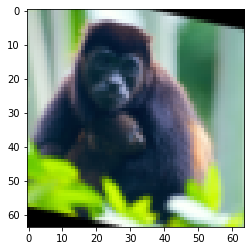

In [ ]:
labels= info_overview['Common Name']
test_model(model,val_ds,labels)

## Save Model

In [ ]:
#torch.save(model.state_dict,'v1Monkey.pth')